In [507]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from nuscenes import NuScenes


# Retrieve Data


In [508]:
nusc = NuScenes(
    version="v1.0-mini",
    dataroot="../../nuscenes/",
    verbose=False,
)

In [509]:
scene = nusc.scene[0]
scene


{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [510]:
sample = nusc.get("sample", scene["first_sample_token"])
sample["data"]


{'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
 'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
 'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
 'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
 'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
 'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
 'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
 'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
 'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
 'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
 'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
 'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'}

In [511]:
sample_data = nusc.get("sample_data", sample["data"]["CAM_FRONT"])
sample_data


{'token': 'e3d495d4ac534d54b321f50006683844',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': 'e3d495d4ac534d54b321f50006683844',
 'calibrated_sensor_token': '1d31c729b073425e8e0202c5c6e66ee1',
 'timestamp': 1532402927612460,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402927612460.jpg',
 'prev': '',
 'next': '68e8e98cf7b0487baa139df808641db7',
 'sensor_modality': 'camera',
 'channel': 'CAM_FRONT'}

In [512]:
calibrated_sensor = nusc.get(
    "calibrated_sensor", sample_data["calibrated_sensor_token"]
)
calibrated_sensor

{'token': '1d31c729b073425e8e0202c5c6e66ee1',
 'sensor_token': '725903f5b62f56118f4094b46a4470d8',
 'translation': [1.70079118954, 0.0159456324149, 1.51095763913],
 'rotation': [0.4998015430569128,
  -0.5030316162024876,
  0.4997798114386805,
  -0.49737083824542755],
 'camera_intrinsic': [[1266.417203046554, 0.0, 816.2670197447984],
  [0.0, 1266.417203046554, 491.50706579294757],
  [0.0, 0.0, 1.0]]}

# Perspective Transform


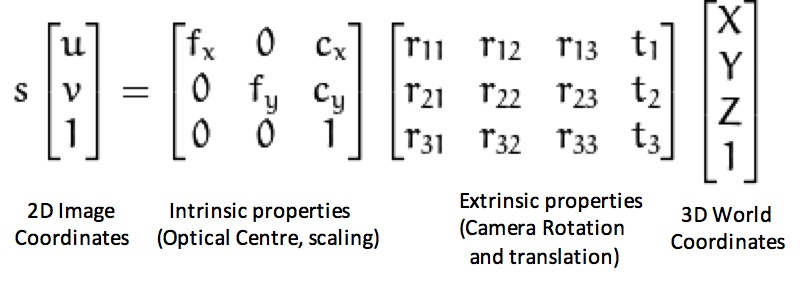


In [513]:
intrinsics = np.array(calibrated_sensor["camera_intrinsic"])

fx = intrinsics[0][0]
fy = intrinsics[1][1]
cx = intrinsics[0][2]
cy = intrinsics[1][2]

intrinsics

array([[1.26641720e+03, 0.00000000e+00, 8.16267020e+02],
       [0.00000000e+00, 1.26641720e+03, 4.91507066e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [514]:
from pyquaternion import Quaternion

rotation = Quaternion(calibrated_sensor["rotation"])
rotation.transformation_matrix

array([[ 5.68477868e-03, -5.63666773e-03,  9.99967955e-01,
         0.00000000e+00],
       [-9.99983517e-01, -8.37115272e-04,  5.68014846e-03,
         0.00000000e+00],
       [ 8.05071338e-04, -9.99983763e-01, -5.64133364e-03,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [515]:
calibrated_sensor["translation"]


[1.70079118954, 0.0159456324149, 1.51095763913]

In [516]:
extrinsics = np.zeros((3, 4))

extrinsics[:3, :3] = rotation.transformation_matrix[:3, :3]
extrinsics[:, 3] = np.array(calibrated_sensor["translation"]).T

extrinsics

array([[ 5.68477868e-03, -5.63666773e-03,  9.99967955e-01,
         1.70079119e+00],
       [-9.99983517e-01, -8.37115272e-04,  5.68014846e-03,
         1.59456324e-02],
       [ 8.05071338e-04, -9.99983763e-01, -5.64133364e-03,
         1.51095764e+00]])

In [517]:
from nuscenes.utils.geometry_utils import transform_matrix

transformation_matrix = transform_matrix(
    calibrated_sensor["translation"],
    rotation,
    inverse=True,
)
print(transformation_matrix.shape)
transformation_matrix

(4, 4)


array([[ 5.68477868e-03, -9.99983517e-01,  8.05071338e-04,
         5.06031940e-03],
       [-5.63666773e-03, -8.37115272e-04, -9.99983763e-01,
         1.52053325e+00],
       [ 9.99967955e-01,  5.68014846e-03, -5.64133364e-03,
        -1.69230345e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

# get_visible_mask function


--- Configs ---

-> Top-left and bottom right coordinates of map region, in meters

map_extents: [-25.0, 1.0, 25.0, 50.0]

-> Spacing between adjacent grid cells in the map, in meters

map_resolution: 0.25


In [518]:
# function from label generation utils


def get_visible_mask(instrinsics, image_width, extents, resolution):
    # Get calibration parameters
    fu, cu = instrinsics[0, 0], instrinsics[0, 2]

    # Construct a grid of image coordinates
    x1, z1, x2, z2 = extents
    x, z = np.arange(x1, x2, resolution), np.arange(z1, z2, resolution)
    ucoords = x / z[:, None] * fu + cu

    # Return all points which lie within the camera bounds
    return (ucoords >= 0) & (ucoords < image_width)

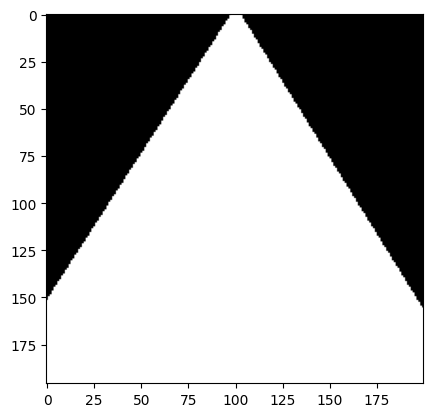

In [519]:
mask = get_visible_mask(
    intrinsics,
    sample_data["width"],
    extents=[-25.0, 1.0, 25.0, 50.0],
    resolution=0.25,
)
plt.imshow(mask, cmap="gray")


In [520]:
fx, cx = intrinsics[0, 0], intrinsics[0, 2]
print(fx, cx)


1266.417203046554 816.2670197447984


In [521]:
x1, z1, x2, z2 = [-25.0, 1.0, 25.0, 50.0]


In [522]:
resolution = 0.25

x, z = np.arange(x1, x2, resolution), np.arange(z1, z2, resolution)

print(x.shape)
print(z.shape)


(200,)
(196,)


In [523]:
# z[:, None] to add new empty dim ,i.e, convert (n,) to (n,1)

(x / z[:, None]).shape


(196, 200)

In [524]:
np.array([1, 2, 3, 4]) / np.array([1, 2, 3])[:, None]

array([[1.        , 2.        , 3.        , 4.        ],
       [0.5       , 1.        , 1.5       , 2.        ],
       [0.33333333, 0.66666667, 1.        , 1.33333333]])

In [525]:
ucoords = x / z[:, None] * fx + cx


In [526]:
ucoords


array([[-30844.16305642, -30527.55875566, -30210.9544549 , ...,
         31526.88419362,  31843.48849439,  32160.09279515],
       [-24512.07704119, -24258.79360058, -24005.51015997, ...,
         25384.76075885,  25638.04419946,  25891.32764007],
       [-20290.68636436, -20079.61683052, -19868.54729668, ...,
         21290.01180233,  21501.08133617,  21712.15087001],
       ...,
       [   173.41564764,    179.84416136,    186.27267508, ...,
          1439.83285069,   1446.26136441,   1452.68987813],
       [   176.66237174,    183.05841822,    189.4544647 , ...,
          1436.68352831,   1443.07957479,   1449.47562127],
       [   179.87646545,    186.24037099,    192.60427654, ...,
          1433.56585741,   1439.92976295,   1446.2936685 ]])

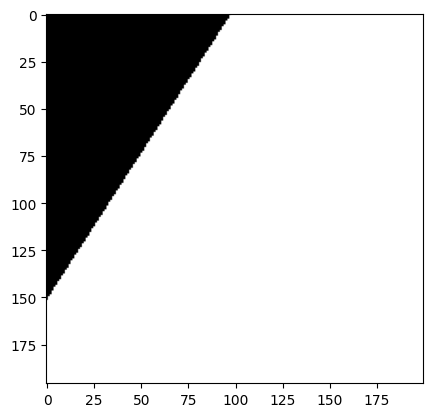

In [527]:
plt.imshow(ucoords >= 0, cmap="gray")


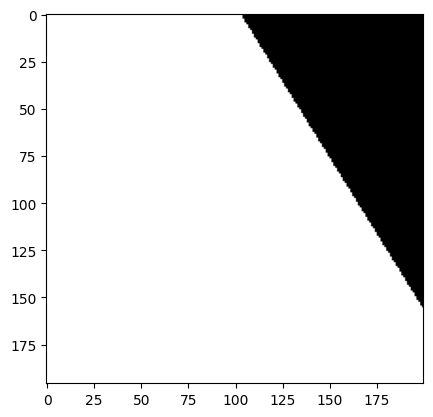

In [528]:
plt.imshow(ucoords < sample_data["width"], cmap="gray")


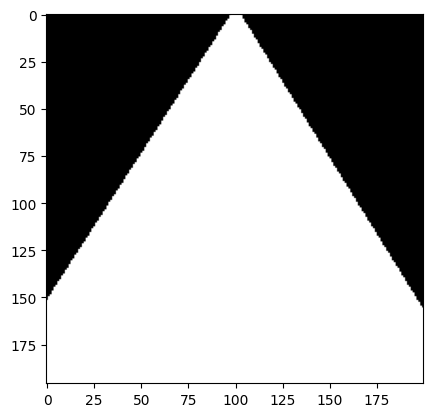

In [529]:
plt.imshow((ucoords >= 0) & (ucoords < sample_data["width"]), cmap="gray")


# Inverse Perspective Mapping


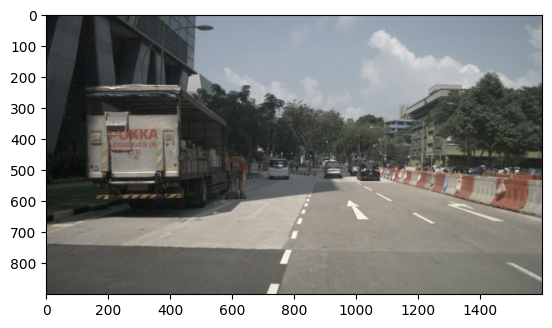

In [530]:
img = cv2.imread("../../nuscenes/" + sample_data["filename"])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)


In [531]:
img.shape


(900, 1600, 3)

In [532]:
from typing import Tuple


def cal_bev_coord(
    u: float,
    v: float,
    intrinsics: np.ndarray,
    map_extents: Tuple[float, float, float, float],
    map_resolution: float,
    car_height: float,
) -> Tuple[float, float]:
    fx = intrinsics[0][0]
    fy = intrinsics[1][1]
    cx = intrinsics[0][2]
    cy = intrinsics[1][2]
    zc = fy * (-car_height) / (v - cy)
    xc = zc * (u - cx) / fx

    ### map_extents: [-25.0, 1.0, 25.0, 50.0]

    x_bev = (xc - map_extents[0]) / map_resolution
    y_bev = (-zc - map_extents[1]) / map_resolution

    return x_bev, y_bev

In [533]:
def calc_ipm_transformation_matrix(
    img,
    intrinsics,
    map_extents,
    map_resolution,
    car_height,
):
    height, width = img.shape[:2]

    pts1 = [
        (0, 0),
        (0, width - 1),
        (height - 1, 0),
        (height - 1, width - 1),
    ]

    pts2 = list()

    for pt1 in pts1:
        pt2 = cal_bev_coord(
            pt1[0],
            pt1[1],
            intrinsics,
            map_extents,
            map_resolution,
            car_height,
        )
        pts2.append(pt2)

    M_ipm = cv2.getPerspectiveTransform(
        np.array(pts1, dtype=np.float32), np.array(pts2, dtype=np.float32)
    )

    return M_ipm

In [534]:
def ipm_transform(
    img,
    intrinsics,
    map_extents,
    map_resolution,
    car_height,
):
    M_ipm = calc_ipm_transformation_matrix(
        img,
        intrinsics,
        map_extents,
        map_resolution,
        car_height,
    )
    bev_width = round((map_extents[2] - map_extents[0]) / map_resolution)
    bev_height = round((map_extents[3] - map_extents[1]) / map_resolution)
    bev = cv2.warpPerspective(img, M_ipm, (bev_width, bev_height))

    return bev

In [535]:
map_resolution = 0.25
map_extents = [-25.0, 1.0, 25.0, 50.0]
car_height = 1.562

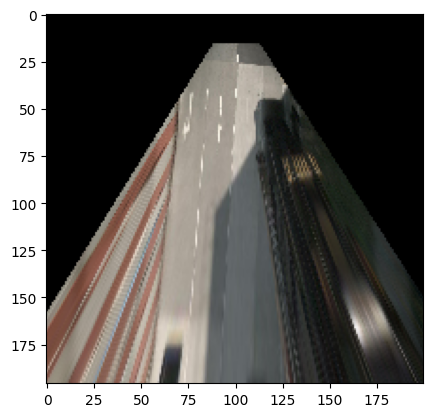

In [536]:
bev = ipm_transform(img, intrinsics, map_extents, map_resolution, car_height)
plt.imshow(bev)


(-0.5, 199.5, 195.5, -0.5)

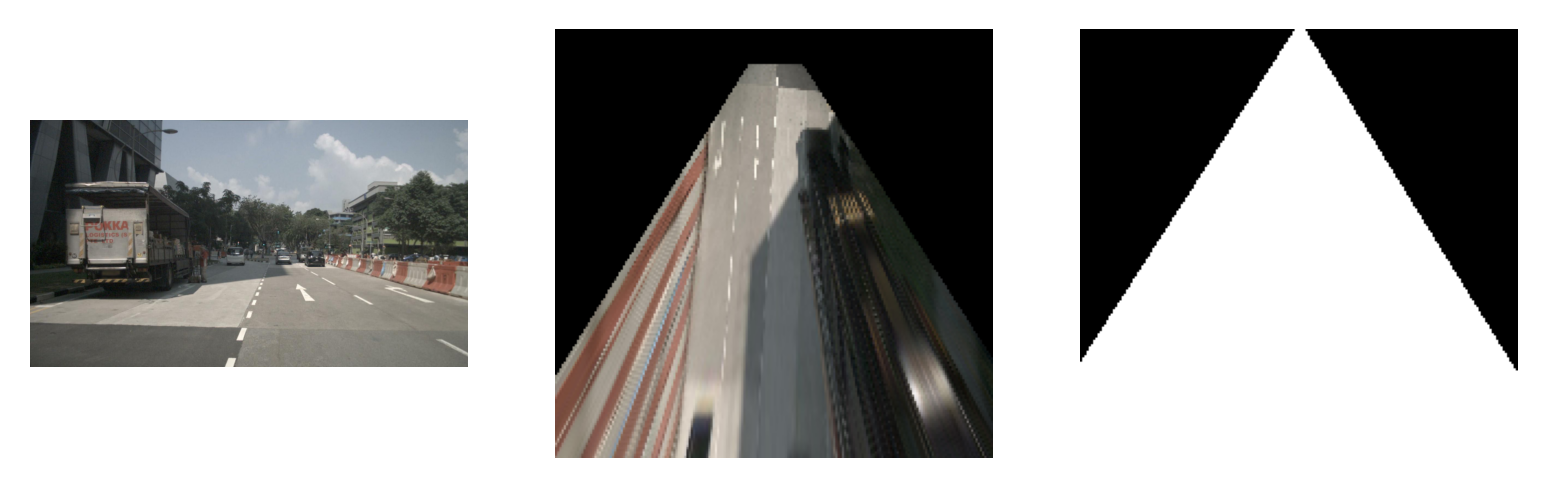

In [537]:
fig, axes = plt.subplots(1, 3, dpi=300)

axes[0].imshow(img)
axes[0].axis("off")

bev = ipm_transform(img, intrinsics, map_extents, map_resolution, car_height)
axes[1].imshow(bev)
axes[1].axis("off")

axes[2].imshow(mask, cmap="gray")
axes[2].axis("off")